# Data Extraction and Detecting Time Series Components

First thing first, let me import the Python libraries first.

In [1]:
import json

import numpy as np

# add ../src to sys.path
import sys
sys.path.append('..')

from FiDaL import (data as dta, optimization as optz, transformations as transform, utils, plot)
from FiDaL.optimization.optimize import PortfolioOptimization

In [2]:
# Read the credentials from credentials.json
with open('../config/credentials.json') as f:
    credentials = json.load(f)
    
    # Read the config from config.json
with open('../config/config.json') as f:
    config = json.load(f)

For the sake of practice, let me work with telecom industry and to do that I pick `AT&T` (T) and `Verizon` (VZ). As a stock price I choose closing price, which is more stable and informative compared to high, low, open. Adjusted closing price would be a good choice. 

The period that I cover is 01/01/2020-06/01/2021 and the stock price data is daily, meaning that we have 253 observations. 

### Download and load the data

Selecting the right data period is crucial for the analysis. The following factors should be considered when selecting the data period:
- **Market changes**: Financial markets undergo structural changes over time. Regulations, economic conditions, technological advancements, and other factors can alter market dynamics. It's crucial to ensure that the data used is still representative of current conditions.
- **More Recent Data**: Some analysts prefer using more recent data (e.g., 3-5 years) on the premise that it better reflects the current market dynamics. Financial markets evolve, and the factors that influenced stock performance a decade ago may not be as relevant today.
- **Specific Asset Characteristics**: Different assets may require different look-back periods based on their volatility, liquidity, and the sectors they represent. For instance, technology stocks may behave differently compared to utility stocks over the same period.
- **Investment Horizon**: Align the data period with your investment horizon. If you are a long-term investor, using a longer historical period may be more appropriate. For shorter-term investments, consider using a shorter data period.
- **Statistical Significance:** Ensure that the data set is large enough to be statistically significant, reducing the risk of anomalies skewing the results.
- Be aware of **regime changes** (significant shifts in market trends or economic conditions) within your data period. These can significantly impact the relevance of historical data.
- **Consider using rolling windows** for your analysis. This technique involves continuously updating the time frame of the data used for the analysis (e.g., always using the most recent five years of data). This can provide a more dynamic view of how optimal weights change over time.

In [68]:
# Create an instance of the YFDataDownloader class
downloader = dta.make_data.YFDataDownloader(config, credentials=credentials)

# Get the data for ticker AT&T (T), Verizon (VZ), and the S&P 500 (SPY) using downloader.get_data()
print(config["data_source_params"])
data_downloaded = downloader.get_data(**config["data_source_params"])
# transform data to a xarray dataset
# data_downloaded = data_downloaded.to_xarray()

{'tickers': ['SNY', 'NESN.SW', 'TM', 'AAPL', '^TNX', '^NSEI'], 'start_date': '2021-01-01', 'end_date': '2024-12-31', 'interval': '1d'}


In [69]:
data = data_downloaded[["Adj Close", "Volume"]]
data.head()

Adj Close                                                         \
                  AAPL    NESN.SW        SNY          TM         ^NSEI   ^TNX   
Date                                                                            
2021-01-01         NaN        NaN        NaN         NaN  14018.500000    NaN   
2021-01-04  127.164154  97.002838  43.559853  153.289993  14132.900391  0.917   
2021-01-05  128.736374  96.259964  43.550922  153.399994  14199.500000  0.955   
2021-01-06  124.402924  94.978470  42.898640  153.529999  14146.250000  1.042   
2021-01-07  128.647934  94.829895  42.970123  152.669998  14137.349609  1.071   

                 Volume                                                 
                   AAPL    NESN.SW        SNY        TM     ^NSEI ^TNX  
Date                                                                    
2021-01-01          NaN        NaN        NaN       NaN  358100.0  NaN  
2021-01-04  143301900.0  4991415.0  1744200.0  315600.0  495000.0  0.0  
2021-01-05   97664900.0  5413155.0   954300.0  231800.0  492500.0  0.0  
2021-01-06  155088000.0  7212007.0  4119000.0  296100.0  632300.0  0.0  
2021-01-07  109578200.0  5379644.0  3781600.0  345000.0  559200.0  0.0

### Data Exploration

**AT&T (T)**:

- **Count**: 737 observations.
- **Mean Price**: Approximately $16.977.
- **Standard Deviation**: About $1.516, indicating moderate price volatility.
- **Minimum Price**: Around $13.198
- **Maximum Price**: Approximately $20.451.

**Verizon (VZ)**:

- **Count**: 737 observations.
- **Mean Price**: Approximately $41.931.
- **Standard Deviation**: About $6.236, suggesting higher price volatility compared to AT&T.
- **Minimum Price**: Around $30.670.
- **Maximum Price**: Approximately $51.376

In [5]:
data = dta.process.FeatureGenerator.calculate_returns(data, column='Adj Close', log=True)

# Calculate expected returns (mean of logarithmic returns)
expected_returns = data["log_returns"].mean()

print("\nExpected Returns:\n", expected_returns)


Expected Returns:
 AAPL       0.000710
NESN.SW   -0.000010
SNY        0.000154
TM         0.000319
^NSEI      0.000658
^TNX       0.001872
dtype: float64


The most important data cleaning steps for us are:
- **Missing Values**: Check for missing values and handle them appropriately. Missing values can cause issues with the analysis and may lead to incorrect conclusions. Common approaches for handling missing values include removing them, imputing them with a value (e.g., mean, median), or using a forward or backward fill.
- **Outliers**: Check for outliers and handle them appropriately. Outliers can skew the analysis and lead to incorrect conclusions. Common approaches for handling outliers include removing them or capping them at a certain value.
- **Data Types**: Ensure that the data types are correct. For instance, numerical values should be represented as floats or integers, and dates should be represented as date objects.
- **Duplicates**: Check for duplicate values and handle them appropriately. Duplicates can cause issues with the analysis and may lead to incorrect conclusions. Common approaches for handling duplicates include removing them or aggregating them.
- **Data Integrity**: Ensure that the data is correct and consistent. For instance, check that the data is in the expected range, and that the values are consistent with other data sources.
- **Data Format**: Ensure that the data is in the expected format. For instance, check that the data is in the expected units (e.g., dollars vs. cents), and that the values are consistent with other data sources.
- **Data Range**: Ensure that the data is within the expected range. For instance, check that the data is within the expected time period, and that the values are consistent with other data sources.
- **Data Granularity**: Ensure that the data is at the expected level of granularity. For instance, check that the data is at the expected frequency (e.g., daily, monthly, quarterly), and that the values are consistent with other data sources.

Let's apply all of these with the expection of outliers, and granulatiry because we can have outliners that are valid as we will see so these are things that we will need to check mostly manually, and granularity is already set to daily.

In [17]:
# dta.validate_data(data,
#         tickers:=config["data_source_params"]["tickers"],
#         start_date=config["data_source_params"]["start_date"])

In [18]:
data = (data.dropna(thresh=data.shape[1]//2)
        .rename(columns={"Adj Close": "price", "Volume": "volume"})
        .swaplevel(i=-2, j=-1, axis=1)
        .sort_index(axis=1))
tickers_dict = {ticker: data[ticker] for ticker in list(data.columns.get_level_values(0).unique())}
tickers_dict["TM"]

,log_returns,price,returns,volume
Date,,,,
2021-01-04,NaN,153.289993,NaN,315600.0
2021-01-05,0.000717,153.399994,0.000718,231800.0
2021-01-06,0.000847,153.529999,0.000847,296100.0
2021-01-07,-0.005617,152.669998,-0.005602,345000.0
2021-01-08,0.001178,152.850006,0.001179,418100.0
...,...,...,...,...
2023-12-01,0.015477,192.740005,0.015597,237500.0
2023-12-04,-0.028257,187.369995,-0.027861,331200.0
2023-12-05,0.003304,187.990005,0.003309,199600.0


### Visual analzysis

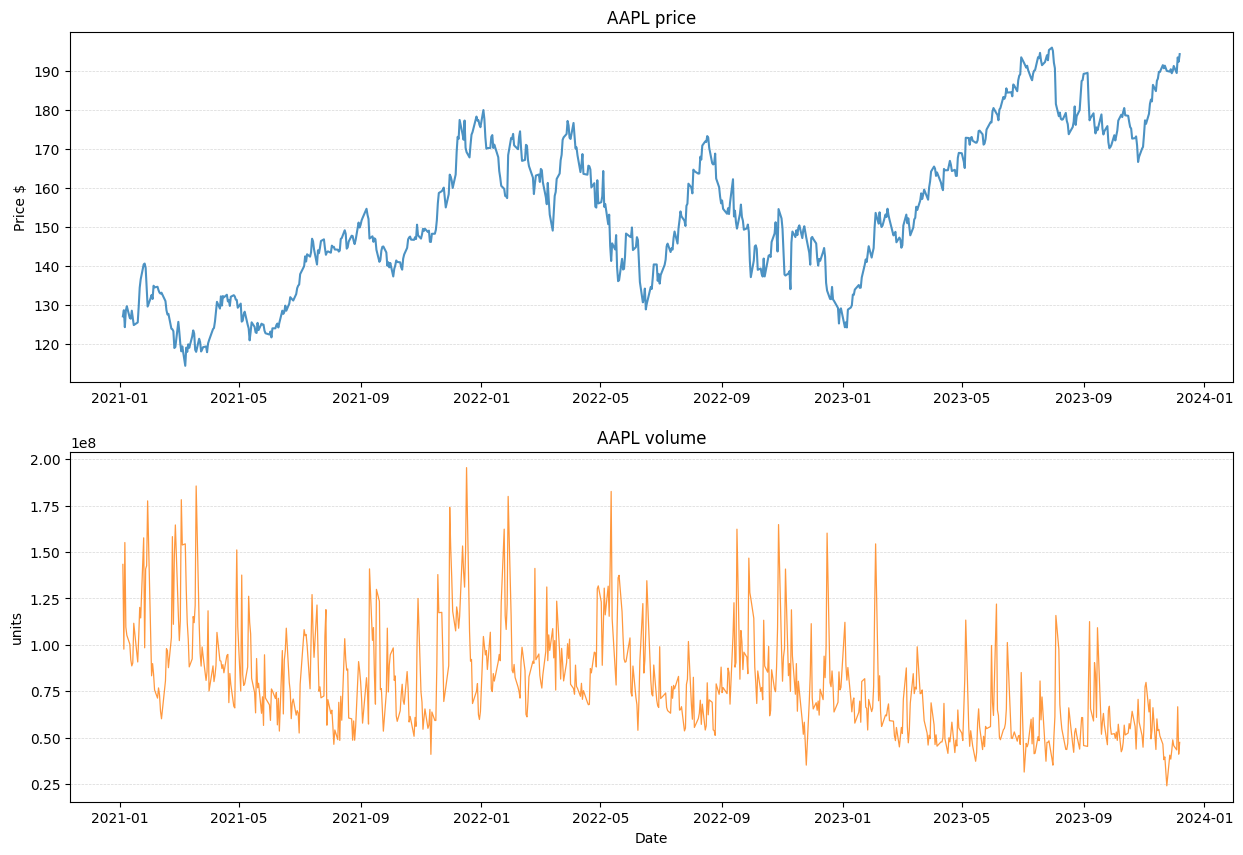

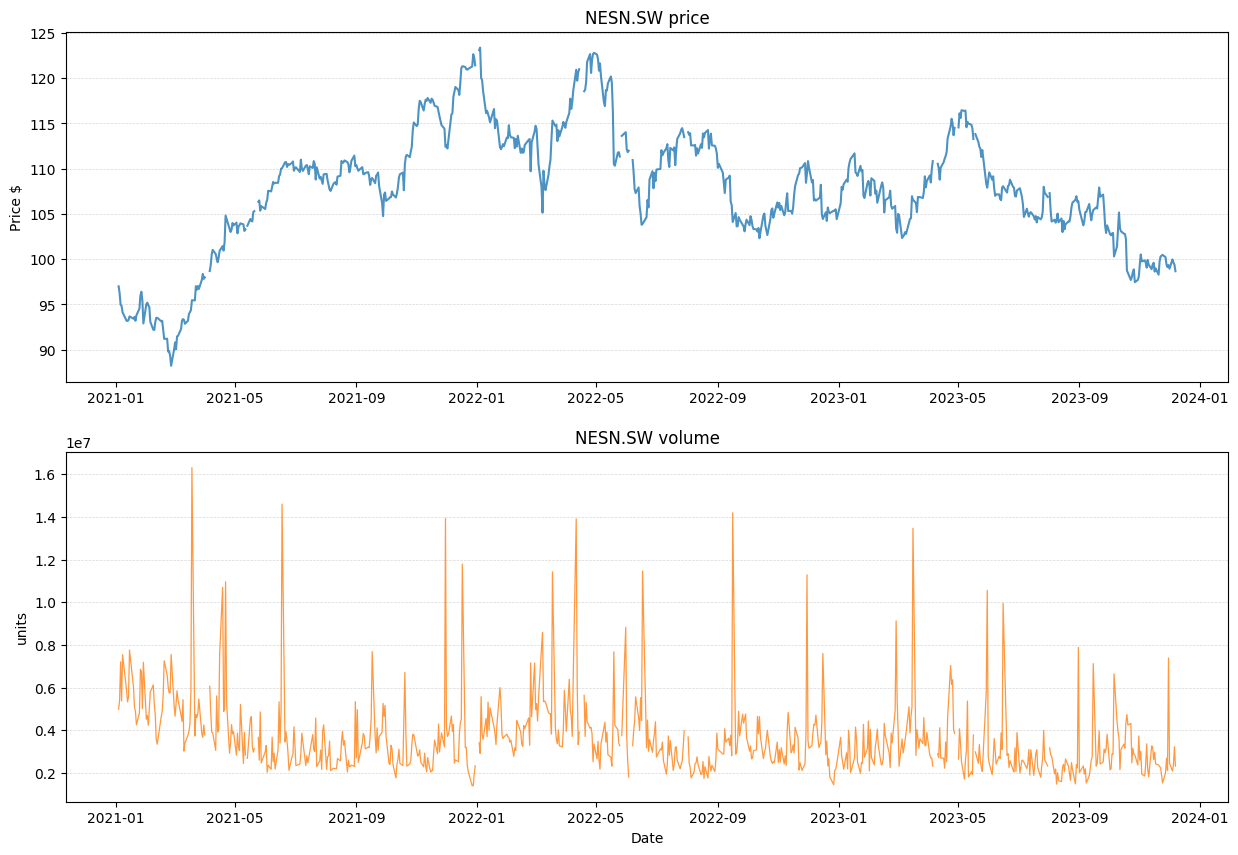

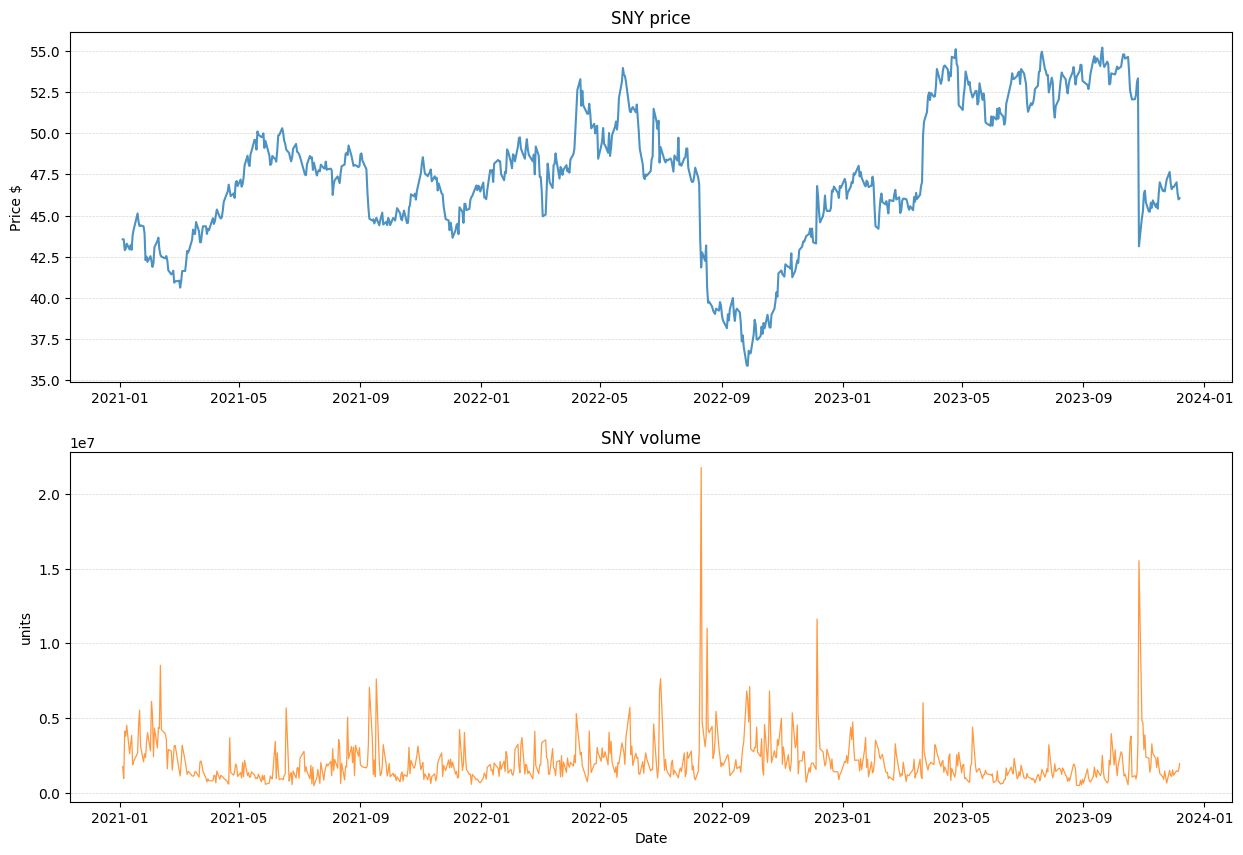

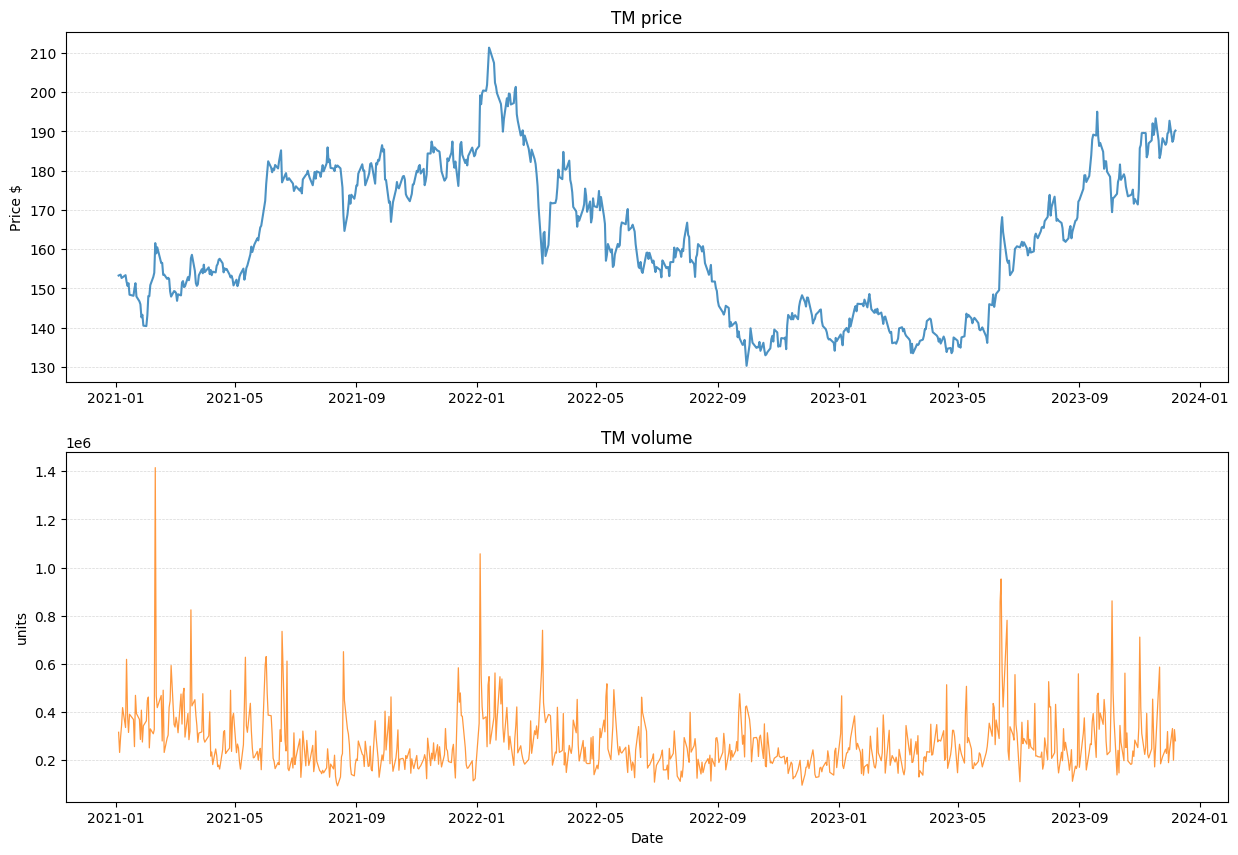

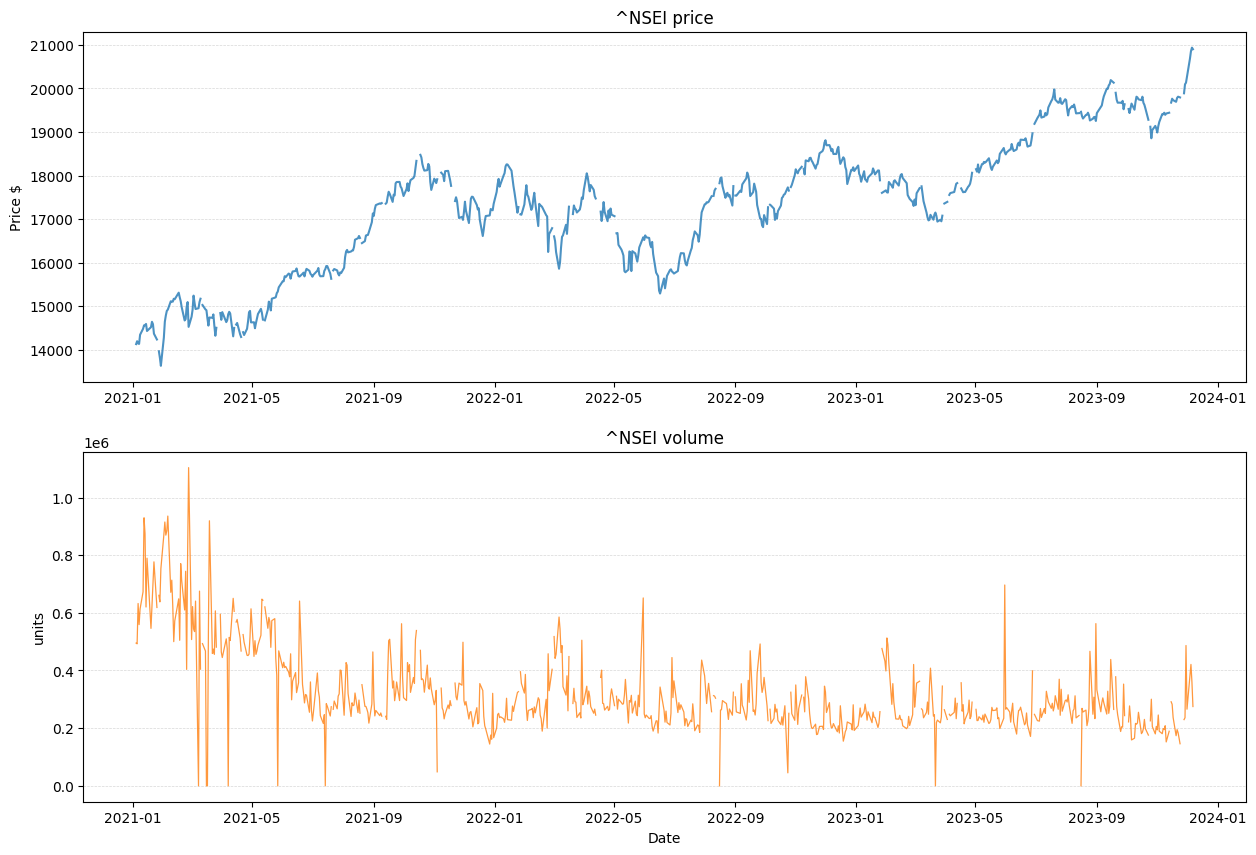

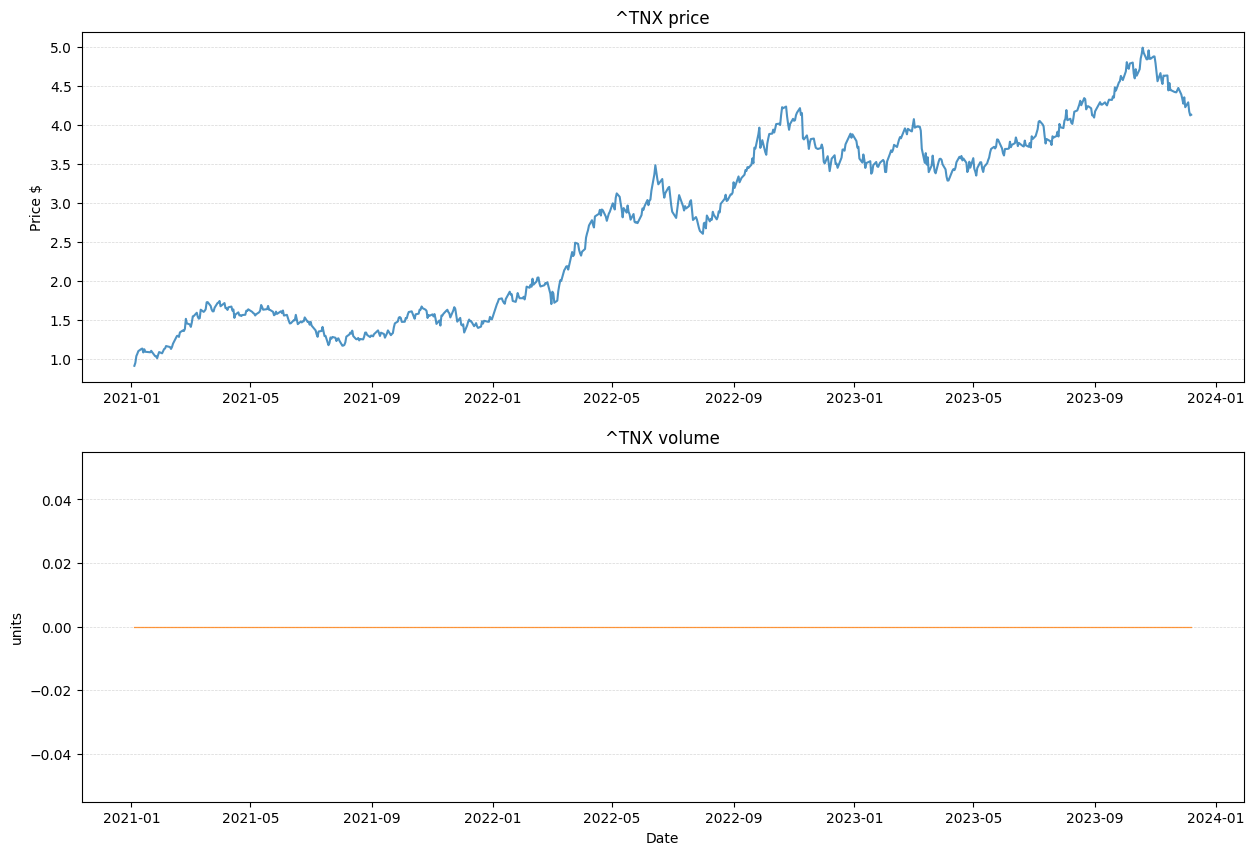

In [60]:
for ticker in tickers_dict.keys():
    plot.adj_close_volume(tickers_dict, ticker, ["price", "volume"], y_log=False)

> Comments for Feb 2014
<!-- This spike is correct:

* On February 24, 2014, [Vodafone Group Plc (LSE:VOD) spun off a 30% stake in Verizon Communications Inc. (NYSE:VZ) for $59.3 billion.](https://www.marketscreener.com/quote/stock/VODAFONE-GROUP-PLC-15867071/news/Vodafone-Group-Plc-completed-the-spin-off-of-30-stake-in-Verizon-Communications-Inc-NYSE-VZ-for-38808632/#:~:text=Vodafone%20Group%20Plc%20(LSE:VOD)%20completed%20the%20spin%2D,and%20$23.9%20billion%20of%20cash.). Vodafone shareholders received all of the Verizon shares and $23.9 billion in cash.

* Vodafone also consolidated its ordinary shares on February 24, 2014. The consolidation was intended to keep Vodafone's share price relatively unchanged.[[1](https://www.bloomberg.com/news/articles/2014-02-21/verizon-stake-sale-cuts-vodafone-s-value-by-half-to-100-billion#:~:text=The%20stock%20consolidation%2C%20in%20a%20bid%20to,changed%2C%20also%20happens%20on%20the%20Feb.%2024.)][[2](https://investors.vodafone.com/sites/vodafone-ir/files/verizon-wireless-transaction/tax-information-on-the-return-of-value.pdf#:~:text=Following%20the%20Return%20of%20Value%2C%20Vodafone%20consolidated,new%20ordinary%20shares%20for%20every%2011%20existing)]

* Verizon became the sole owner of its wireless business in 2014 when it bought Vodafone's 45% stake. Vodafone received $58.9 billion in cash, $60.2 billion in stock, and $11 billion in other consideration.[[3](https://en.wikipedia.org/wiki/Verizon_(mobile_network)#:~:text=Majority%20owner%20Verizon%20Communications%20became,$11%20billion%20in%20other%20consideration.)]

* Verizon shares admitted to listing on London Stock Exchange [[4](https://www.reuters.com/article/verizoncommunications-brief-idINWLB007BD20140224/)] -->

### Moving Average

#### US Bonds 10Y

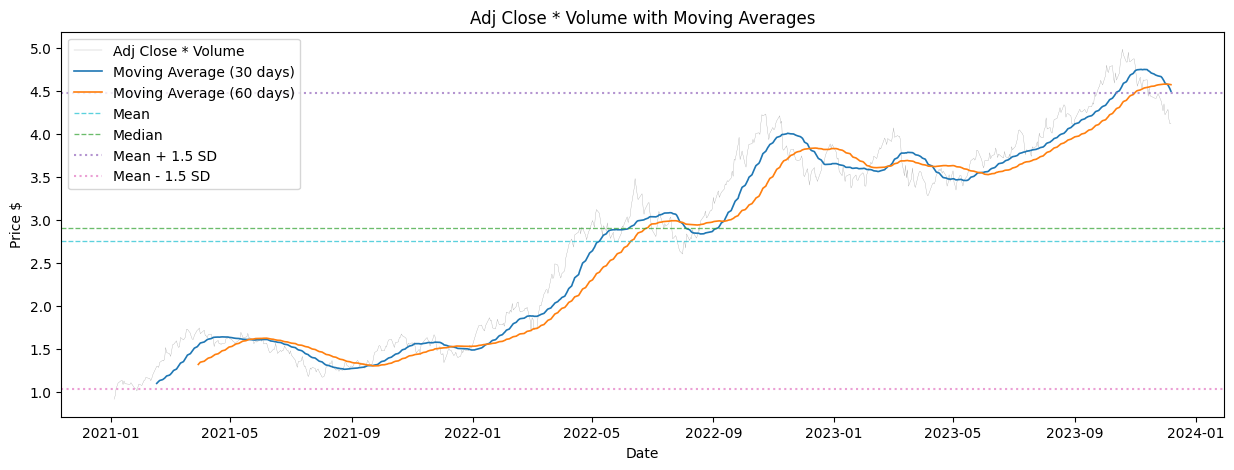

In [66]:
plot.moving_average(adj_close:=tickers_dict["^TNX"]["price"],
                    volume:=1,
                    window_sizes=[30, 60], include_stats=True, log_scale=False)

#### NIFTY 50 index

In [62]:
plot.moving_average(adj_close:=tickers_dict["^NSEI"]["price"],
                    volume:=tickers_dict["^NSEI"]["volume"],
                    window_sizes=[30, 60], include_stats=True, log_scale=False)

dict_keys(['AAPL', 'NESN.SW', 'SNY', 'TM', '^NSEI', '^TNX'])

#### APPLE

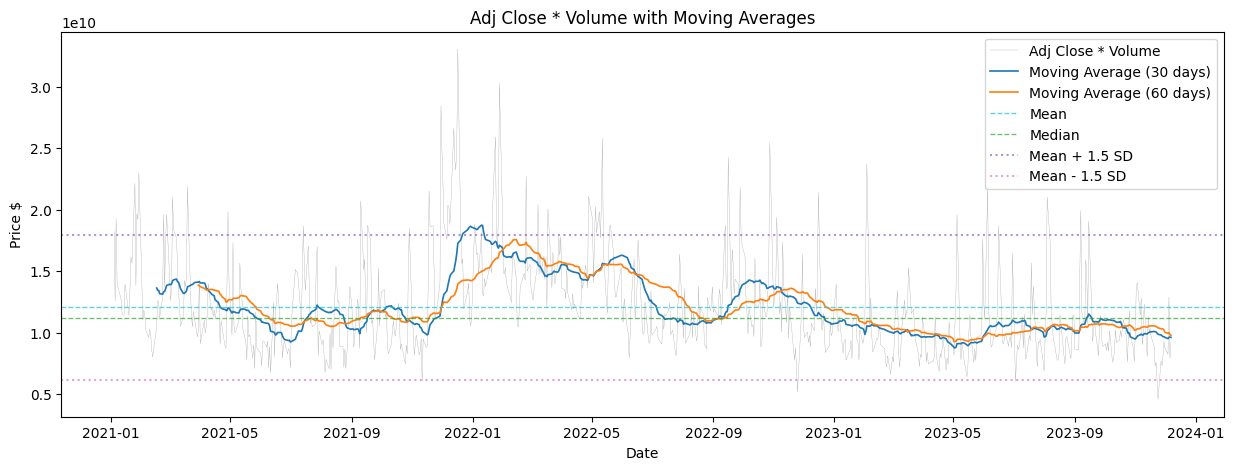

In [64]:
plot.moving_average(adj_close:=tickers_dict["AAPL"]["price"],
                    volume:=tickers_dict["AAPL"]["volume"],
                    window_sizes=[30, 60], include_stats=True, log_scale=False)

In [70]:
data

Adj Close                                                         \
                  AAPL    NESN.SW        SNY          TM         ^NSEI   ^TNX   
Date                                                                            
2021-01-01         NaN        NaN        NaN         NaN  14018.500000    NaN   
2021-01-04  127.164154  97.002838  43.559853  153.289993  14132.900391  0.917   
2021-01-05  128.736374  96.259964  43.550922  153.399994  14199.500000  0.955   
2021-01-06  124.402924  94.978470  42.898640  153.529999  14146.250000  1.042   
2021-01-07  128.647934  94.829895  42.970123  152.669998  14137.349609  1.071   
...                ...        ...        ...         ...           ...    ...   
2023-12-04  189.429993  99.970001  47.020000  187.369995  20686.800781  4.288   
2023-12-05  193.419998  99.620003  46.340000  187.990005  20855.099609  4.171   
2023-12-06  192.320007  99.400002  45.980000  189.889999  20937.699219  4.121   
2023-12-07  194.270004  98.669998  46.060001  190.240005  20901.150391  4.129   
2023-12-08         NaN        NaN        NaN         NaN  20956.550781    NaN   

                 Volume                                                 
                   AAPL    NESN.SW        SNY        TM     ^NSEI ^TNX  
Date                                                                    
2021-01-01          NaN        NaN        NaN       NaN  358100.0  NaN  
2021-01-04  143301900.0  4991415.0  1744200.0  315600.0  495000.0  0.0  
2021-01-05   97664900.0  5413155.0   954300.0  231800.0  492500.0  0.0  
2021-01-06  155088000.0  7212007.0  4119000.0  296100.0  632300.0  0.0  
2021-01-07  109578200.0  5379644.0  3781600.0  345000.0  559200.0  0.0  
...                 ...        ...        ...       ...       ...  ...  
2023-12-04   43389500.0  2093471.0  1468700.0  331200.0  381100.0  0.0  
2023-12-05   66628400.0  2407221.0  1423300.0  199600.0  421000.0  0.0  
2023-12-06   41089700.0  3233146.0  1441500.0  326700.0  359200.0  0.0  
2023-12-07   47433900.0  2327426.0  1947000.0  280200.0  275000.0  0.0  
2023-12-08          NaN        NaN        NaN       NaN       0.0  NaN  

[763 rows x 12 columns]

In [72]:
# Calculating daily returns
daily_returns = data[['Adj Close']].ffill().pct_change()

# Calculating volatility (annualized standard deviation of daily returns)
volatility = daily_returns.std() * (252**0.5)

# Calculating the correlation matrix
correlation_matrix = daily_returns.corr()

# Displaying the calculated metrics
daily_returns_summary = daily_returns.describe()
volatility_summary = volatility
correlation_matrix_summary = correlation_matrix

daily_returns_summary, volatility_summary, correlation_matrix_summary


(        Adj Close                                                            
              AAPL     NESN.SW         SNY          TM       ^NSEI        ^TNX
 count  761.000000  761.000000  761.000000  761.000000  762.000000  761.000000
 mean     0.000708    0.000068    0.000190    0.000397    0.000569    0.002315
 std      0.017374    0.009585    0.015072    0.015059    0.009036    0.025943
 min     -0.058680   -0.050260   -0.191262   -0.061962   -0.047781   -0.099088
 25%     -0.008584   -0.004596   -0.007176   -0.008438   -0.004179   -0.014570
 50%      0.000303    0.000399    0.000000    0.000319    0.000228    0.001156
 75%      0.010421    0.005506    0.008436    0.008740    0.006111    0.019546
 max      0.088974    0.044038    0.080570    0.069247    0.047424    0.092873,
 Adj Close  AAPL       0.275802
            NESN.SW    0.152153
            SNY        0.239268
            TM         0.239061
            ^NSEI      0.143447
            ^TNX       0.411828
 dtype: float64,


In [92]:
from scipy.optimize import minimize
import numpy as np

# Function to calculate portfolio returns, volatility, and Sharpe Ratio
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

# Function to minimize (for optimization) - here we minimize the negative Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Function to get the portfolio volatility
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

# Constraints for the optimizer (weights sum to 1)
def check_sum(weights):
    return np.sum(weights) - 1

# Define the mean returns and the covariance matrix for the portfolio
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Number of assets in the portfolio
num_assets = len(mean_returns)

# The risk-free rate assumption (approximate current 10-year bond yield)
risk_free_rate = 0.02

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': check_sum})
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess (equal distribution)
init_guess = num_assets * [1. / num_assets,]

# Optimization function
opt_results = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_results.x

# Displaying optimal weights for each asset
optimal_weights_dict = dict(zip(['AAPL', 'NESN.SW', 'SNY', 'TM', 'NSEI', 'TNX'],
                                np.round(optimal_weights, 3)))
# optimal_weights_dict

# Display the portfolio distribution
for asset, weight in optimal_weights_dict.items():
    print(f"{asset}: {weight:.2%}")

AAPL: 20.50%
NESN.SW: 0.00%
SNY: 0.00%
TM: 0.00%
NSEI: 46.90%
TNX: 32.60%


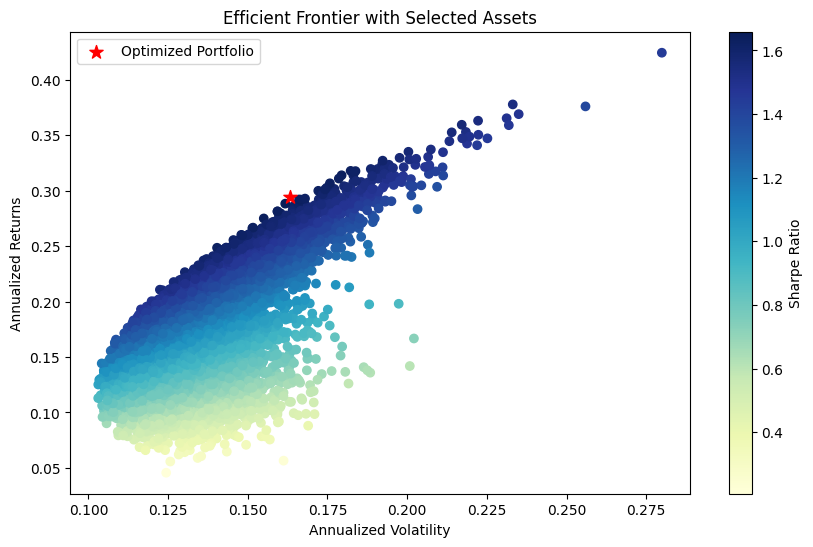

(0.16314624334091532, 0.2940205218327277)

In [81]:
from scipy.optimize import minimize



def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Mean returns and covariance matrix
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Number of assets and initial setup for optimization
num_assets = len(mean_returns)
risk_free_rate = 0.02
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))
init_guess = num_assets * [1. / num_assets,]

# Portfolio optimization
opt_results = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_results.x

# Calculate expected portfolio return and volatility with optimized weights
optimal_volatility, optimal_return = portfolio_annualized_performance(optimal_weights, mean_returns, cov_matrix)

# Function to generate portfolios for the efficient frontier
def generate_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_std, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std
    return results

# Generate random portfolios for the efficient frontier
num_portfolios = 10000
random_portfolios = generate_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(random_portfolios[0,:], random_portfolios[1,:], c=random_portfolios[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier with Selected Assets')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Returns')
plt.colorbar(label='Sharpe Ratio')

# Plotting the optimized portfolio
plt.scatter(optimal_volatility, optimal_return, marker='*', color='r', s=100, label='Optimized Portfolio')
plt.legend()

plt.show()

optimal_volatility, optimal_return


In [95]:
# Simulating Scenario 1: Significant Market Downturn

# Applying a hypothetical 20% decrease in stock prices
downturn_impact = -0.20  # 20% decrease

# Adjusting the daily returns for the stocks and stock index
adjusted_returns = daily_returns.copy()
adjusted_returns *= (1 + downturn_impact)

# Calculate the new portfolio value with the adjusted returns
new_optimal_volatility, new_optimal_return = portfolio_annualized_performance(optimal_weights, adjusted_returns.mean(), adjusted_returns.cov())

# Comparing new results with the original
original_return, original_volatility = optimal_return, optimal_volatility
new_return, new_volatility = new_optimal_return, new_optimal_volatility

{
    "original_return":original_return,
    "original_volatility":original_volatility,
    "new_return":new_return,
    "new_volatility":new_volatility
    }

{'original_return': 0.2940205218327277,
 'original_volatility': 0.16314624334091532,
 'new_return': 0.23521641746618221,
 'new_volatility': 0.13051699467273228}

In [101]:
# Simulating Scenario 2: Interest Rate Spike

# Assuming an interest rate spike affects bond yields significantly, we simulate this by increasing the TNX returns.
# We also consider the potential negative impact on stock prices due to higher interest rates.
interest_spike_impact_on_bond = 0.25  # 25% increase in bond yields
interest_spike_impact_on_stocks = -0.10  # 10% decrease in stock prices

# Adjusting the daily returns for the bond and stocks
adjusted_returns_scenario_2 = daily_returns.copy()
adjusted_returns_scenario_2[("Adj Close", '^TNX')] *= (1 + interest_spike_impact_on_bond)
adjusted_returns_scenario_2 *= (1 + interest_spike_impact_on_stocks)

# Calculate the new portfolio value with the adjusted returns
new_optimal_volatility_scenario_2, new_optimal_return_scenario_2 = portfolio_annualized_performance(optimal_weights, adjusted_returns_scenario_2.mean(), adjusted_returns_scenario_2.cov())

# Comparing new results with the original for Scenario 2
new_return_scenario_2, new_volatility_scenario_2 = new_optimal_return_scenario_2, new_optimal_volatility_scenario_2

{
    "original_return":original_return,
    "original_volatility":original_volatility,
    "new_return_scenario_2":new_return_scenario_2,
    "new_volatility_scenario_2":new_volatility_scenario_2
    }

{'original_return': 0.2940205218327277,
 'original_volatility': 0.16314624334091532,
 'new_return_scenario_2': 0.30743773010292585,
 'new_volatility_scenario_2': 0.172346479824209}

In [103]:
# Simulating Scenario 3: Sector-Specific Shock
# For this simulation, let's assume a shock to the technology sector, which would significantly impact Apple (AAPL).

# Assuming a 15% decrease in the technology sector (specifically impacting AAPL)
sector_shock_impact = -0.15  # 15% decrease in tech sector

# Adjusting the daily returns for AAPL to reflect the sector-specific shock
adjusted_returns_scenario_3 = daily_returns.copy()
adjusted_returns_scenario_3[('Adj Close', 'AAPL')] *= (1 + sector_shock_impact)

# Calculate the new portfolio value with the adjusted returns
new_optimal_volatility_scenario_3, new_optimal_return_scenario_3 = portfolio_annualized_performance(optimal_weights, adjusted_returns_scenario_3.mean(), adjusted_returns_scenario_3.cov())

# Comparing new results with the original for Scenario 3
new_return_scenario_3, new_volatility_scenario_3 = new_optimal_return_scenario_3, new_optimal_volatility_scenario_3

{
    "original_return":original_return,
    "original_volatility":original_volatility,
    "new_return_scenario_3":new_return_scenario_3,
    "new_volatility_scenario_3":new_volatility_scenario_3
}

{'original_return': 0.2940205218327277,
 'original_volatility': 0.16314624334091532,
 'new_return_scenario_3': 0.28854061073566023,
 'new_volatility_scenario_3': 0.16044649298834093}

### Portfolio Optimization

We will use two approaches for portfolio optimization:
1. **Convex Optimization (`cvxpy`)**: This approach uses convex optimization to minimize the portfolio variance.
2. **Minimization (`scipy.optimize`)**: This approach uses a more general-purpose optimization algorithm (Sequential Least Squares Programming, or SLSQP) to minimize the portfolio volatility.

#### Comparative and Practical Considerations:
1. **Ease of Use**:
    - The `cvxpy` approach may require more familiarity with convex optimization concepts.
    - The `scipy.optimize` approach is more straightforward and is part of a more commonly used general-purpose optimization library.
2. **Flexibility**:
    - Both methods can be adapted for more complex scenarios (e.g., adding more assets).
    - The `scipy.optimize` method might offer more flexibility for custom objective functions and constraints.
3. **Performance and Scalability**:
    - The `cvxpy` approach is generally more efficient for larger, more complex portfolio optimization problems due to its specialization in convex problems.
    - The `scipy.optimize` method, while versatile, might face performance issues or difficulties in finding the global minimum in more complex or non-convex landscapes.
4. **Suitability**:
    - **Convex Optimization (`cvxpy`)**: More suitable for large-scale, complex portfolio optimization problems where **variance minimization** is the sole objective.
    - **Minimization (`scipy.optimize`)**: Better for smaller-scale, less complex problems, or when there is a need for a more general-purpose optimization framework. More focused on **volatility minimization**.

##### Convex Optimization (cvxpy):

**Methodology**

Utilizes convex optimization, specifically designed for problems where the objective function and constraints form a convex set.
The method inherently guarantees finding the global minimum due to the nature of convex problems.

**Objective function**

Specifically focuses on minimizing the quadratic form, which represents the portfolio variance.
Highly suitable for problems where the primary goal is risk (variance) minimization.

##### Implementation description

1. **Objective**: The goal is to minimize the overall variance of the portfolio, which is a measure of risk. By doing so, we aim to find the optimal balance between the stocks that reduces the portfolio's volatility.

2. **Inputs for Optimization**:
   - **Variances $\sigma_{A,B}$**: The variances of the individual stocks (AT&T and Verizon) represent the volatility of each stock.
   - **Correlation $\rho$**: The correlation between the stocks indicates how similarly they move. A high correlation means the stocks tend to move in the same direction.



3. **Covariance**:
   - Covariance $\sigma_{A,B}$ is calculated from the individual stock variances and their correlation. It's a measure of how much the stocks move together.

4. **Optimization Variables**:
   - We will create a vector $\mathbf{x}$ representing the weights of each stock in the portfolio. These weights determine how much of each stock is held in the portfolio.

5. **Covariance Matrix**:
   - The covariance matrix $P$ is a 2x2 matrix composed of the variances and the covariance. This matrix is fundamental in calculating the portfolio variance.

6. **Quadratic Form**:
   - The portfolio variance $\sigma^2_p$) is represented by the quadratic form $\mathbf{x^T} \mathbf{P} \mathbf{x}$. This form combines the weights and the covariance matrix to compute the total variance of the portfolio.

7. **Objective Function**:
   - The objective function in our optimization problem is to minimize the portfolio variance, represented by the quadratic form.

8. **Constraints**:
   - We will set constraints to ensure the weights in vector $\mathbf{x}$ sum up to 1, meaning the total investment is distributed across the two stocks.

9. **Solving the Optimization Problem**:
   - Using these inputs and constraints, we will employ convex optimization (via `cvxpy` library) to find the optimal weights that minimize the portfolio variance.

With these steps, we'll be able to determine the proportion of investment to be allocated to each stock (AT&T and Verizon) to achieve the lowest possible risk, as measured by the portfolio's variance.
This process is a fundamental aspect of modern portfolio theory.

##### Optimization implementation (cvxpy)

In [ ]:
# Optimize portfolio variance
optimal_weights_var, minimized_variance = optz.optimize.optimize_twoasset_portfolio(
    varA := adj_close_A.var(),
    varB := adj_close_B.var(),
    correlation := adj_close_A.corr(adj_close_B)
)

# Print the weights of Stock A and Stock B in the optimized portfolio as percentages
optimal_weights_var_dict = dict(zip(config["data_source_params"]["tickers"], map(round, optimal_weights_var)))

print("Optimal Weights (Variance):")
for stock, weight in optimal_weights_var_dict.items():
    print(f"\t {stock}: {weight:%}")

print(f"Minimized Portfolio Variance: {round(minimized_variance, 5)}")

Optimal Weights (Variance):
	 T: 100.000000%
	 VZ: 0.000000%
Minimized Portfolio Variance: 1.9082


#### Minimization (scipy.optimize):

**Methodology**
- Employs a more general-purpose optimization algorithm (Sequential Least Squares Programming, or SLSQP).
- Can handle a wider range of problems but does not inherently guarantee a global minimum unless the problem is convex.

**Objective function**
- Directly minimizes the portfolio volatility (standard deviation).
- While closely related to variance, focusing on standard deviation might be more intuitive in terms of risk perception.

##### Implementation

In [ ]:
mean_returns = np.array([returns_A.mean(), returns_B.mean()])

# Sample mean returns and covariance matrix for volatility optimization
cov_matrix = np.array([[varA, correlation * np.sqrt(varA * varB)], 
                        [correlation * np.sqrt(varA * varB), varB]])  # Example covariance matrix

# Optimize portfolio volatility
optimal_weights_vol, minimized_volatility = optz.optimize.portfolio_volatility(
    mean_returns,
    cov_matrix
)

optimal_weights_vol_dict = dict(zip(config["data_source_params"]["tickers"], map(round, optimal_weights_vol)))

print("Optimal Weights (Volatility):")
for stock, weight in optimal_weights_vol_dict.items():
    print(f"\t {stock}: {weight:%}")

print(f"Minimized Portfolio Volatility: {round(minimized_volatility, 5)}")

Optimal Weights (Volatility):
	 T: 100.000000%
	 VZ: 0.000000%
Minimized Portfolio Volatility: 1.98006


#### Interpretation

The portfolio optimization results, focusing on both variance and volatility minimization, suggest investing entirely in AT&T (T) and not in Verizon (VZ). In both cases, the optimization process indicates a 100% allocation to AT&T. This outcome suggests that, under the given model and input parameters, AT&T is perceived as a less risky or more favorable investment compared to Verizon, whether considering variance or volatility as the measure of risk.

Key Points:
- **Optimization Consistency**: Both variance and volatility optimizations yielded the same investment strategy, indicating a consistent risk profile assessment for the two stocks based on the model's inputs.
- **Minimized Risk Measures**: The minimized portfolio variance and volatility are solely attributed to AT&T, as Verizon has no weight in the optimized portfolio.
- **Lack of Diversification**: The recommendation for a 100% allocation in a single asset goes against the principle of diversification, typically a cornerstone of risk management in portfolio theory.
- **Consideration of Model Limitations**: The extremity of this recommendation suggests a need to re-evaluate the input parameters, constraints, and the model's assumptions. Real-world applicability should be carefully considered, taking into account broader market conditions and individual investment objectives and risk tolerance.

In summary, while the model suggests AT&T as the preferable investment for risk minimization, it's important to approach these results with caution and consider the broader context of portfolio management and investment strategy.

### Other Optimization Strategies

There are other portfolio optimization strategies that can be used to achieve different objectives. These include:
- **Maximizing Sharpe Ratio**: This approach aims to maximize the Sharpe ratio, which is a measure of risk-adjusted return.
- **Risk Parity**: This approach aims to equalize the risk contribution of each asset in the portfolio.
- **Target Return**: This approach aims to achieve a target return while minimizing risk.
- **Maximizing Diversification**: This approach aims to maximize the diversification ratio, which is a measure of portfolio diversification.
- **Maximizing Information Ratio**: This approach aims to maximize the information ratio, which is a measure of risk-adjusted return relative to a benchmark.
- **Maximizing Sortino Ratio**: This approach aims to maximize the Sortino ratio, which is a measure of risk-adjusted return relative to downside risk.
- **Maximizing Omega Ratio**: This approach aims to maximize the Omega ratio, which is a measure of risk-adjusted return relative to downside risk.

I have implemented some of these strategies in the `PortfolioOptimization` class in the `optimization` module. Let's take a look at how they work.

In [ ]:
portfolio_opt = optz.optimize.PortfolioOptimization(data["log_returns"].cov())

optimization_results = {
    'min_variance': portfolio_opt.optimize(objective='min_variance'),
    # 'max_sharpe':portfolio_opt.optimize(objective='max_sharpe', returns=expected_returns, risk_free_rate=0.01),
    'risk_parity': portfolio_opt.optimize(objective='risk_parity', risk_contributions_target=[0.6, 0.4]),
    'target_return': portfolio_opt.optimize(objective='target_return', returns=expected_returns, target_return=-1),
    'max_diversification': portfolio_opt.optimize(objective='max_diversification')
}
optimization_results

target_return=-1


{'min_variance': {'weights': array([0.00016664, 0.00021154]),
  'objective': 2.3717582206953432e-11},
 'risk_parity': {'weights': array([9.99999941e-01, 3.99753331e-08]),
  'objective': 0.7080428860481719},
 'target_return': {'weights': array([0.00048071, 0.00063812]),
  'objective': 2.0671399136660535e-10},
 'max_diversification': {'weights': array([9.99999975e-01, 2.34660648e-08]),
  'objective': 0.015769970024764223}}

### References

- [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)